# Compare 2 Surf En

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from calculations import observables as calc
from calculations import triangular as tri
from manage import utils

sns.set_theme()

###

data_dirs = [
    "/home/max/projects/apfc/data/01n0VBx/Bx/0.100000",
    "/home/max/projects/apfc/data/01n0VBx/Bx/0.100000"
]

surf_en_indeces = [0, 0]

names = ["new", "old"]

colors = ["r", "b"]
line_widths = [1, 1]

normalize = False

add_lim = 0.1
plot_zero_line = True
apply_lims = True

0.0 0.0


 [-3.15511665e-28 -4.87958358e-04] [[0. 0.]
 [0. 0.]] 


new eps: -0.0000, gamma0: -0.0005
0.0 0.0


 [-3.15511665e-28 -4.87958358e-04] [[0. 0.]
 [0. 0.]] 


old eps: -0.0000, gamma0: -0.0005


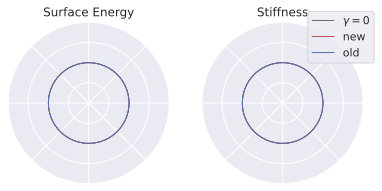

In [2]:
def norm(arr):
    ret = arr - np.min(arr)
    return ret / np.max(ret) 

configs = []
thetas = []
thetas_str = []
surf_ens = []
stiffs = []
fits = []

for data_dir in data_dirs:

    ### Config ###

    config_path = f"{data_dir}/config.json"
    with open(config_path, "r") as f:
        config = json.load(f)

    ### Surf En ###

    surf_en = pd.read_csv(f"{data_dir}/evaluate/surf_en.csv", index_col=0)
    surf_en = surf_en.apply(pd.to_numeric)

    ### Thetas ###

    theta_str = surf_en.columns.to_numpy()
    theta = utils.get_thetas(config)

    ### stiffness ###

    stiff = pd.read_csv(f"{data_dir}/evaluate/stiff.csv", index_col=0)
    stiff = stiff.apply(pd.to_numeric)

    ## fits ###

    fit = pd.read_csv(f"{data_dir}/evaluate/fits.csv", index_col=0)
    fit = fit.apply(pd.to_numeric)

    ### Fill ###

    div = config["thetaDiv"]
    theta = utils.fill(theta, div, True)

    ### Appends ###normalize
    
    configs.append(config)
    surf_ens.append(surf_en)
    thetas.append(theta)
    thetas_str.append(theta_str)
    stiffs.append(stiff)
    fits.append(fit)

###

fig = plt.figure()
ax_surf = plt.subplot(121, projection="polar")
ax_stiff = plt.subplot(122, projection="polar")

ax_surf.set_aspect("equal")
ax_stiff.set_aspect("equal")

plot_stiff = []
plot_surf = []
surf_lim = [0., 0.]
stiff_lim = [0., 0.]

for i in range(len(surf_ens)):

    surf = surf_ens[i].iloc[surf_en_indeces[i], :].to_numpy()
    stiff = stiffs[i].iloc[surf_en_indeces[i], :].to_numpy()

    if normalize:

        surf = norm(surf)
        stiff = norm(stiff)

    plot_stiff.append(stiff)
    plot_surf.append(surf)

    surf_lim[0] = np.min([surf_lim[0], np.min(surf)])
    stiff_lim[0] = np.min([stiff_lim[0], np.min(stiff)])

    surf_lim[1] = np.max([surf_lim[1], np.max(surf)])
    stiff_lim[1] = np.max([stiff_lim[1], np.max(stiff)])

surf_lim[1] += add_lim
stiff_lim[1] += add_lim

surf_lim[0] -= add_lim
stiff_lim[0] -= add_lim

if surf_lim[0] < 0 < surf_lim[1] and plot_zero_line:
    ax_surf.plot(thetas[0], np.zeros(thetas[0].shape), c="black", lw=0.5)

if stiff_lim[0] < 0 < stiff_lim[1] and plot_zero_line:
    ax_stiff.plot(thetas[0], np.zeros(thetas[0].shape), c="black", label="$\\gamma=0$", lw=0.5)

for i in range(len(plot_surf)):

    ax_surf.plot(thetas[i], plot_surf[i], c=colors[i], label=names[i], lw=line_widths[i])
    ax_stiff.plot(thetas[i], plot_stiff[i], c=colors[i], label=names[i], lw=line_widths[i])

    try:
        eps, gamma0 = tri.fit_surf_en(thetas[i], plot_surf[i])
        print(names[i], f"eps: {eps:.4f}, gamma0: {gamma0:.4f}")
    except ValueError as e:
        pass

ax_surf.set_title("Surface Energy")
ax_stiff.set_title("Stiffness")
ax_stiff.legend(bbox_to_anchor=(1.1, 1.1))

ax_surf.set_xticklabels([])
ax_surf.set_yticklabels([])
ax_stiff.set_xticklabels([])
ax_stiff.set_yticklabels([])

if apply_lims:
    ax_surf.set_ylim(surf_lim)
    ax_stiff.set_ylim(stiff_lim)

plt.show()

# Plot Volume 1D

In [ ]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from calculations import observables
from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/01n0"
plot_i = 8
add_max = 5
use_real_min = False
ignore_eta_index = {}

do_polar_plot = True

use_config_max = True # has higher prio than calc_min_max
calc_min_max = True

hide_x_axis_label = True
hide_y_axis_label = False

In [ ]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

#################

df_fits = pd.read_csv(f"{sim_path}/evaluate/eval.csv", index_col=(0, 1))
df_radius = df_fits.iloc[df_fits.index.get_level_values(1) == "radius"]

thetas = df_radius.columns.astype(float)

In [ ]:
fig = plt.figure()

if do_polar_plot:
    ax = plt.subplot(111, projection="polar")
    ax.set_aspect("equal")
    if hide_x_axis_label:
        ax.set_xticklabels([])
    if hide_y_axis_label:
        ax.set_yticklabels([])
else:
    ax = plt.subplot(111)

max_val = 0.
min_val = 1e10

radius_row = df_radius.iloc[plot_i]

max_val = np.max([max_val, np.max(radius_row)])
min_val = np.min([min_val, np.min(radius_row)])

ax.plot(thetas, radius_row)

if use_config_max:
    ax.set_ylim([0, config["xlim"]])
elif calc_min_max:
    ax.set_ylim([min_val if use_real_min else 0, max_val + add_max])

plt.show()

# Reconstruct 2D from 1D theta sims

In [ ]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/05n0"
plot_i = -1

pt_size = 1

In [ ]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

x_full = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
x, _ = utils.get_positive_range(x_full, np.zeros(x_full.shape))
y = np.zeros(x.shape)
xy = np.array([x, y])

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        # this condition is to avoid double printing of the bounds
        if theta_i == thetas.shape[0] - 1:
            continue

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        _, eta_sum = utils.get_positive_range(x_full, eta_sum)

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size)

plt.show()

# Reconstruct 2D from 1D with Tangents

In [ ]:
%config InlineBackend.figure_formats = ['png']
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from manage import utils
from manage import read_write as rw
from calculations import observables

sns.set_theme()

sim_path = "/home/max/projects/apfc/data/06base"
plot_i = -1

pt_size = 0.01

line_plot_color="g"
line_plot_width = 2
line_add_rot = 0.#np.pi/6

alpha = 1

line_angles = np.array([
    i * np.pi/3 for i in range(6)
])

In [ ]:
line_angles += line_add_rot

sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

eta_count = len(config["G"])
line_count = rw.count_lines(f"{sim_path}/eta_files/0.0000/out_0.txt")

thetas = utils.get_thetas(config)
thetas_str = [f"{theta:.4f}" for theta in thetas]

thetas_angle_is = []
for line_angle in line_angles:
    theta_diff = np.abs(thetas - line_angle)
    theta_i = np.argmin(theta_diff)
    thetas_angle_is.append(theta_i)

x_line = np.linspace(-config["xlim"], config["xlim"], config["numPtsX"])
is_get_0_i = (x_line >= 0).nonzero()
x = x_line[is_get_0_i]
y = np.zeros(x.shape)
xy = np.array([x, y])
dx = np.abs(x[0]-x[1])

# fmt: off
rot_90_deg = np.array([
    [np.cos(np.pi/2), -np.sin(np.pi/2)],
    [np.sin(np.pi/2), np.cos(np.pi/2)]
])
# fmt: on

if plot_i < 0:
    plot_i = line_count - np.abs(plot_i)

fig = plt.figure()
ax = plt.subplot(111)
ax.set_aspect("equal")

for div_i in range(config["thetaDiv"]):
    for theta_i, theta in enumerate(thetas):

        theta_dir = f"{sim_path}/eta_files/{theta:.4f}"
        etas = rw.read_all_etas_at_line(
            theta_dir, plot_i, config["numPtsX"], config["numPtsY"], eta_count
        )

        theta = theta + div_i * 2. * np.pi / config["thetaDiv"]

        rot = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        rot_xy = rot.dot(xy)

        eta_sum = np.zeros(etas[0].shape)
        for eta_i in range(eta_count):
            eta_sum += etas[eta_i]**2

        eta_sum = eta_sum[is_get_0_i]

        ax.scatter(rot_xy[0], rot_xy[1], c=eta_sum, s=pt_size, alpha=alpha)

        if theta_i in thetas_angle_is:
            
            r, _ = observables.get_phase_volumes(eta_sum, dx)
            xy_base = np.array([r*np.cos(theta), r*np.sin(theta)])
            xy_line = rot_90_deg.dot(xy_base)

            m = xy_line[1] / xy_line[0]
            n = xy_base[1] - m * xy_base[0]

            print(f"{thetas[theta_i]:.4f}, r={r:.4f}, m={m:.4f}, n={n:.4f}")

            y_line = m * x_line + n
            line_bounds = np.logical_and(
                y_line < config["xlim"],
                y_line > -config["xlim"]
            )

            y_line_plot = y_line[line_bounds]
            x_line_plot = x_line[line_bounds]

            if m > 1e5:

                ax.vlines(
                    xy_base[0], 
                    -config["xlim"], 
                    config["xlim"],
                    color=line_plot_color,
                    lw=line_plot_width
                )

            else:

                ax.plot(
                    x_line_plot, 
                    y_line_plot, 
                    c=line_plot_color, 
                    lw=line_plot_width
                )
            

plt.show()

# Plot Fits for Varying Parameter

In [3]:
%config InlineBackend.figure_formats = ['svg']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from manage import utils

sim_path = "/home/max/projects/apfc/data/01n0VBx"
sim_i = -1

colors = sns.color_palette()

eps_color = colors[0]
gamma0_color = colors[1]

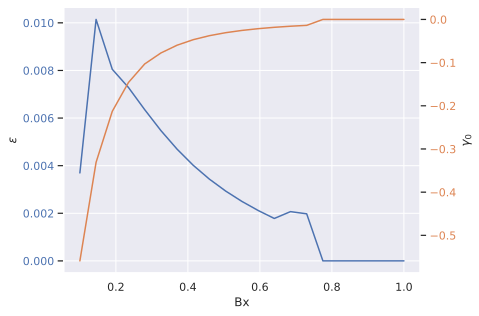

In [4]:
sim_path = utils.make_path_arg_absolute(sim_path)
config = utils.get_config(sim_path)

vary_param = config["varyParam"]
vary_values = np.linspace(
    config["varyStart"],
    config["varyEnd"],
    config["varyAmount"]
)

vary_dir = f"{sim_path}/{config['varyParam']}"

fit_values = pd.DataFrame(
    columns=["eps", "gamma0"], index=range(vary_values.shape[0])
)

for vary_i, vary_val in enumerate(vary_values):

    vary_sim_dir = f"{vary_dir}/{utils.get_vary_val_dir_name(vary_val)}"
    df_fits = pd.read_csv(f"{vary_sim_dir}/evaluate/fits.csv", index_col=0)

    fit_i = sim_i
    if fit_i < 0:
        fit_i = df_fits.shape[0] - np.abs(fit_i) - 1

    fit_values.loc[vary_i, "eps"] = df_fits.loc[fit_i, "eps"]
    fit_values.loc[vary_i, "gamma0"] = df_fits.loc[fit_i, "gamma0"]

fig = plt.figure()

ax_eps = plt.subplot(111)
ax_eps.plot(vary_values, fit_values["eps"], color=eps_color)
ax_eps.set_ylabel("$\\varepsilon$")
ax_eps.tick_params(axis="y", labelcolor=eps_color)

ax_gamma0 = ax_eps.twinx()
ax_gamma0.plot(vary_values, fit_values["gamma0"], color=gamma0_color)
ax_gamma0.set_ylabel("$\\gamma_0$")
ax_gamma0.grid(visible=None)
ax_gamma0.tick_params(axis="y", labelcolor=gamma0_color)

ax_eps.set_xlabel(config["varyParam"])

plt.show()